In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Import**

In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
import torch
import torch.nn.init as init  # For weight initialization

from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# **Data**

In [5]:
data = pd.read_csv('/content/drive/MyDrive/HW_2Q2/teleCust1000t.csv')
df = pd.DataFrame(data)

In [6]:
print("Shape of the dataset:", df.shape)

Shape of the dataset: (1000, 12)


In [7]:
df.head()

,region,tenure,age,marital,address,income,ed,employ,retire,gender,reside,custcat
0,2,13,44,1,9,64.0,4,5,0.0,0,2,1
1,3,11,33,1,7,136.0,5,5,0.0,0,6,4
2,3,68,52,1,24,116.0,1,29,0.0,1,2,3
3,2,33,33,0,12,33.0,2,0,0.0,1,1,1
4,2,23,30,1,9,30.0,1,2,0.0,0,4,3


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   region   1000 non-null   int64  
 1   tenure   1000 non-null   int64  
 2   age      1000 non-null   int64  
 3   marital  1000 non-null   int64  
 4   address  1000 non-null   int64  
 5   income   1000 non-null   float64
 6   ed       1000 non-null   int64  
 7   employ   1000 non-null   int64  
 8   retire   1000 non-null   float64
 9   gender   1000 non-null   int64  
 10  reside   1000 non-null   int64  
 11  custcat  1000 non-null   int64  
dtypes: float64(2), int64(10)
memory usage: 93.9 KB


In [9]:
print(df.isnull().sum())

region     0
tenure     0
age        0
marital    0
address    0
income     0
ed         0
employ     0
retire     0
gender     0
reside     0
custcat    0
dtype: int64


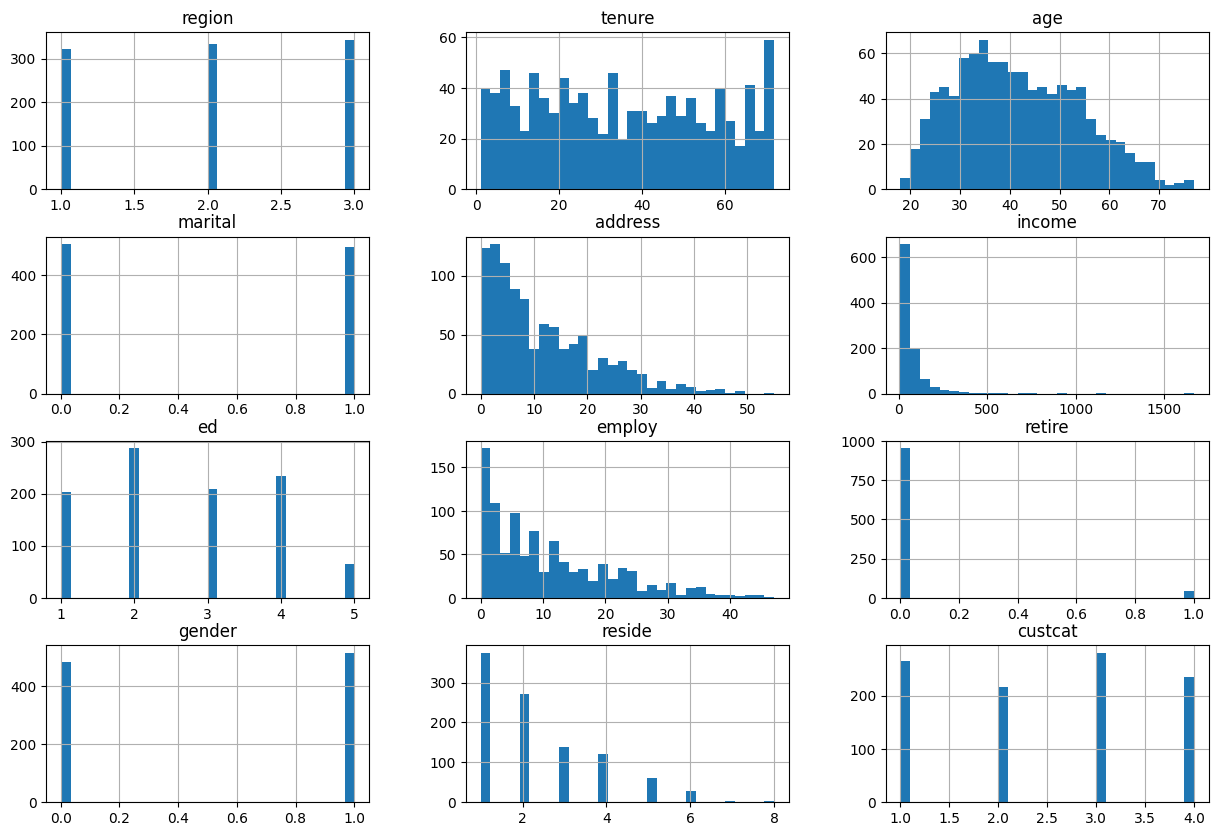

In [10]:
df.hist(bins=30, figsize=(15,10))
plt.show()

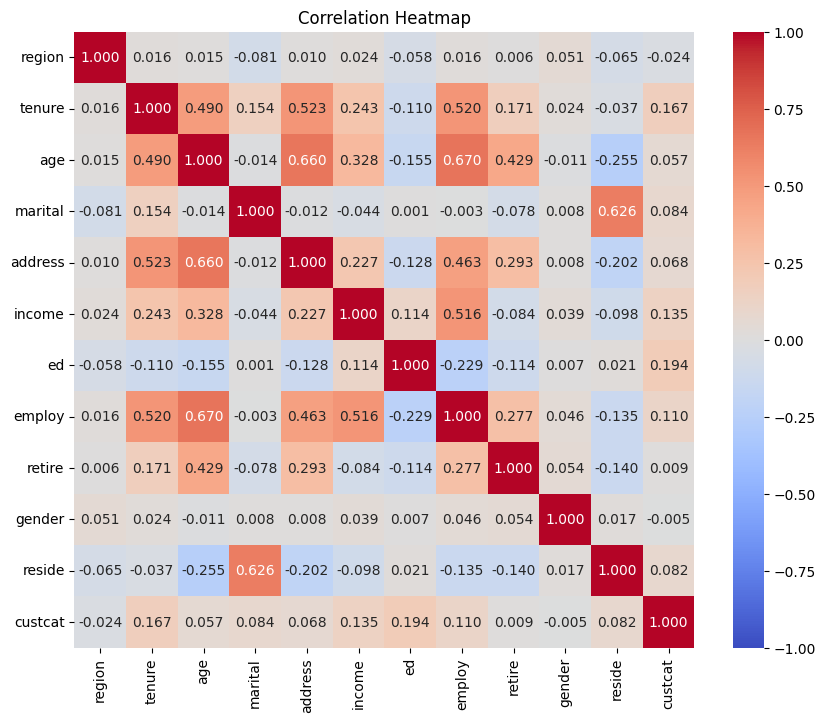

In [11]:
corr_matrix = df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".3f",
    cmap='coolwarm',
    vmin=-1, vmax=1
)
plt.title("Correlation Heatmap")
plt.show()

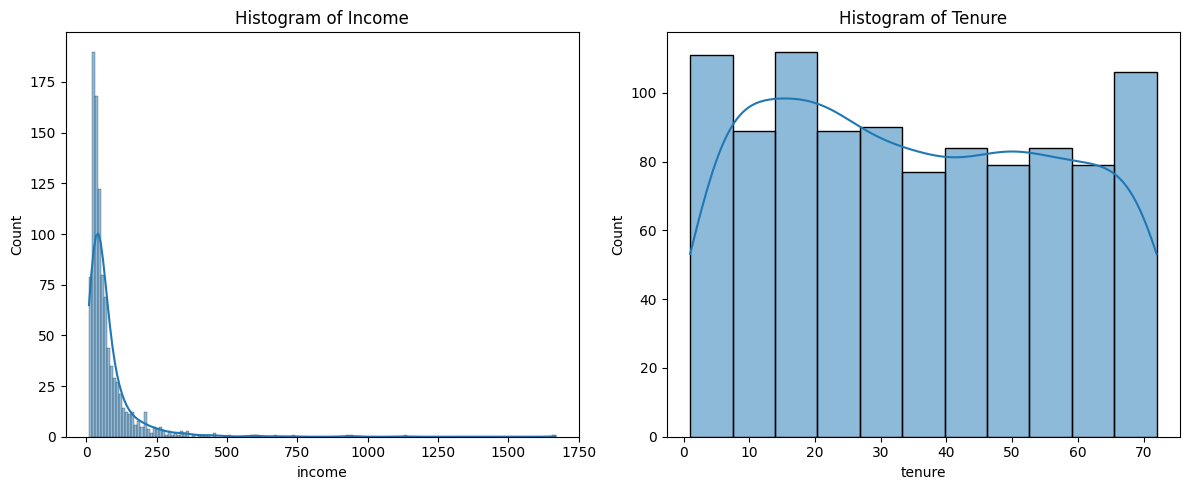

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(data=df, x='income', kde=True, ax=axes[0])
axes[0].set_title('Histogram of Income')

sns.histplot(data=df, x='tenure', kde=True, ax=axes[1])
axes[1].set_title('Histogram of Tenure')

plt.tight_layout()
plt.show()

In [15]:
X = df.drop('custcat', axis=1)

y = data["custcat"] - 1
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.3,
    random_state=73
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    random_state=73
)


scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("X_train_scaled shape:", X_train_scaled.shape)
print("X_val_scaled shape:  ", X_val_scaled.shape)
print("X_test_scaled shape: ", X_test_scaled.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:  ", y_val.shape)
print("y_test shape: ", y_test.shape)

X_train_scaled shape: (700, 11)
X_val_scaled shape:   (150, 11)
X_test_scaled shape:  (150, 11)
y_train shape: (700,)
y_val shape:   (150,)
y_test shape:  (150,)


In [16]:
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)

X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.long)


X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)


train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [17]:
y_train.value_counts()

,count
custcat,
2,192
0,182
3,166
1,160


# **Model 1**

In [ ]:
# Define the model
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleNN, self).__init__()
        self.hidden = nn.Linear(input_size, hidden_size)
        self.output = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.relu(self.hidden(x))
        x = self.output(x)
        return x

In [ ]:
# Training and evaluation function
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs):
    train_loss, val_loss, train_acc, val_acc = [], [], [], []
    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * X_batch.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)
        train_loss.append(running_loss / total)
        train_acc.append(correct / total)

        # Validation phase
        model.eval()
        running_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                running_loss += loss.item() * X_batch.size(0)
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == y_batch).sum().item()
                total += y_batch.size(0)
        val_loss.append(running_loss / total)
        val_acc.append(correct / total)
    return train_loss, val_loss, train_acc, val_acc



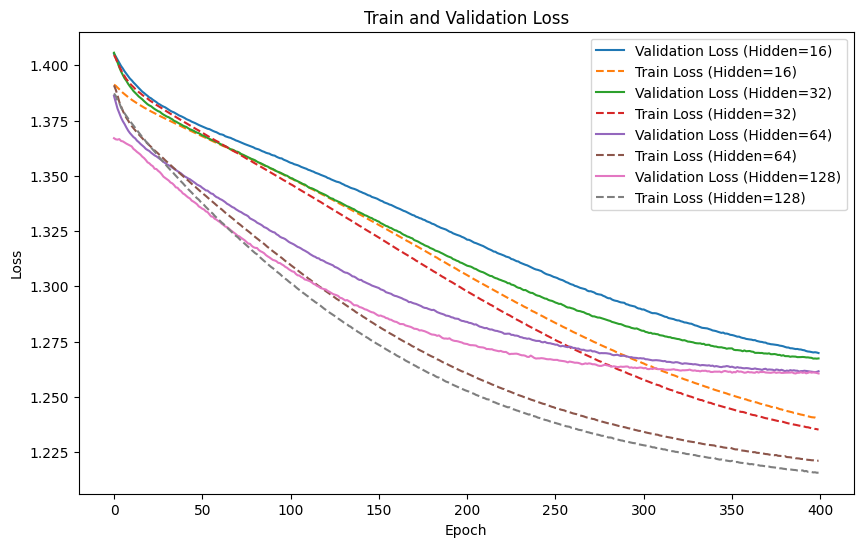

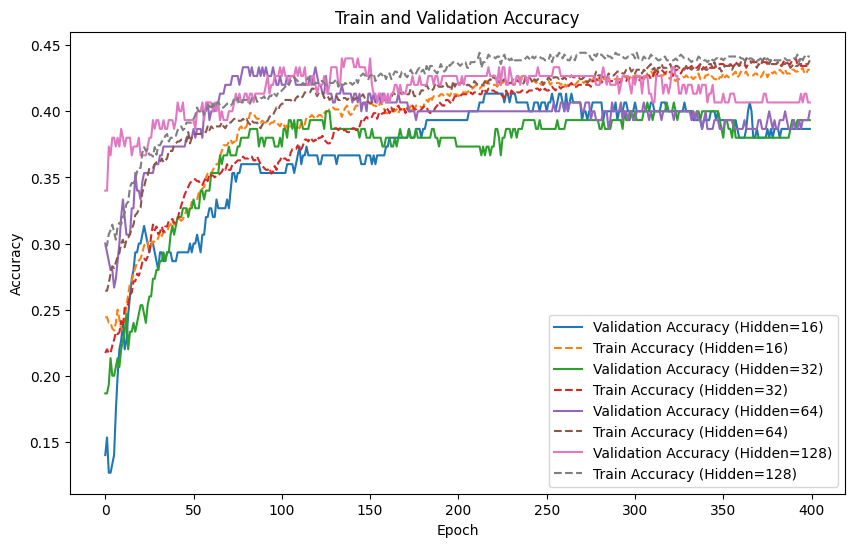

The best model has a hidden layer size of 128 with the lowest validation loss at epoch 387. Validation loss: 1.2606

Classification Report for the Best Model:
              precision    recall  f1-score   support

           0       0.55      0.62      0.58        39
           1       0.38      0.27      0.31        30
           2       0.42      0.50      0.45        44
           3       0.47      0.41      0.43        37

    accuracy                           0.46       150
   macro avg       0.45      0.45      0.45       150
weighted avg       0.46      0.46      0.45       150



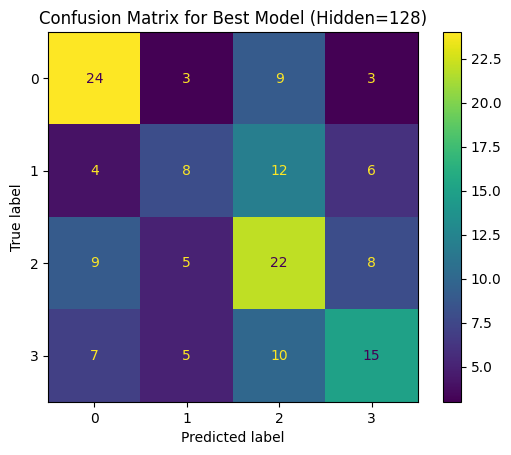

In [ ]:
# Training configurations
input_size = X_train_tensor.shape[1]
output_size = len(y_train.unique())
hidden_sizes = [16, 32, 64, 128]
epochs = 400
results = []

for hidden_size in hidden_sizes:
    model = SimpleNN(input_size, hidden_size, output_size)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    train_loss, val_loss, train_acc, val_acc = train_model(
        model, train_loader, val_loader, criterion, optimizer, epochs
    )
    results.append({
        "hidden_size": hidden_size,
        "train_loss": train_loss,
        "val_loss": val_loss,
        "train_acc": train_acc,
        "val_acc": val_acc,
        "model": model
    })

# Save only the last epoch's results to CSV
last_epoch_data = []
for res in results:
    last_epoch_data.append({
        "hidden_size": res["hidden_size"],
        "train_loss": res["train_loss"][-1],
        "val_loss": res["val_loss"][-1],
        "train_acc": res["train_acc"][-1],
        "val_acc": res["val_acc"][-1],
    })

df_last_epoch = pd.DataFrame(last_epoch_data)
df_last_epoch.to_csv("results_last_epoch.csv", index=False)

# Plot losses and accuracies
plt.figure(figsize=(10, 6))
for res in results:
    plt.plot(res["val_loss"], label=f'Validation Loss (Hidden={res["hidden_size"]})')
    plt.plot(res["train_loss"], linestyle='--', label=f'Train Loss (Hidden={res["hidden_size"]})')
plt.title("Train and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
for res in results:
    plt.plot(res["val_acc"], label=f'Validation Accuracy (Hidden={res["hidden_size"]})')
    plt.plot(res["train_acc"], linestyle='--', label=f'Train Accuracy (Hidden={res["hidden_size"]})')
plt.title("Train and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Find the best model based on the minimum validation loss
best_model = min(results, key=lambda x: min(x["val_loss"]))
best_epoch = best_model["val_loss"].index(min(best_model["val_loss"])) + 1
best_hidden_size = best_model["hidden_size"]

# Print the best model information
print(f"The best model has a hidden layer size of {best_hidden_size} with the lowest validation loss "
      f"at epoch {best_epoch}. Validation loss: {min(best_model['val_loss']):.4f}")

# Evaluate the best model on the test set
best_model["model"].eval()
y_true, y_pred = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = best_model["model"](X_batch)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(y_batch.tolist())
        y_pred.extend(predicted.tolist())

# Generate confusion matrix and classification report
cm = confusion_matrix(y_true, y_pred)
print("\nClassification Report for the Best Model:")
print(classification_report(y_true, y_pred))
ConfusionMatrixDisplay(cm).plot()
plt.title(f"Confusion Matrix for Best Model (Hidden={best_hidden_size})")
plt.show()


# **Model 2**

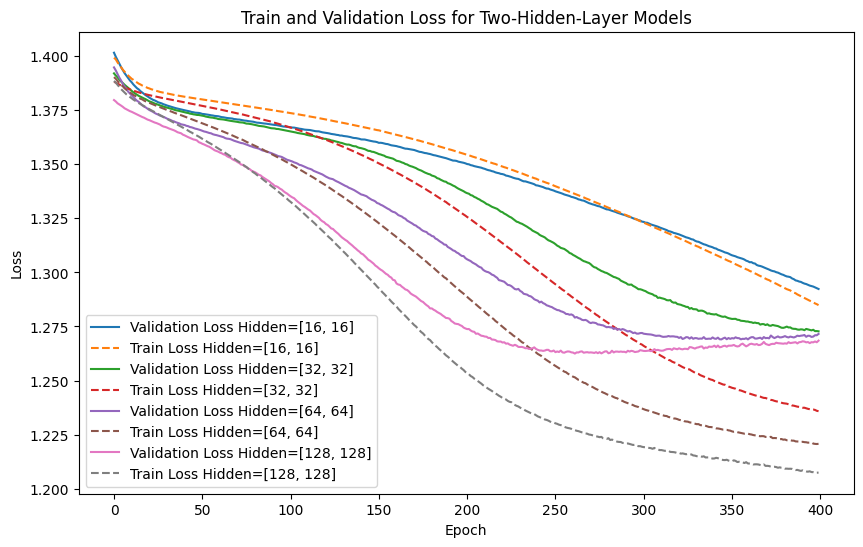

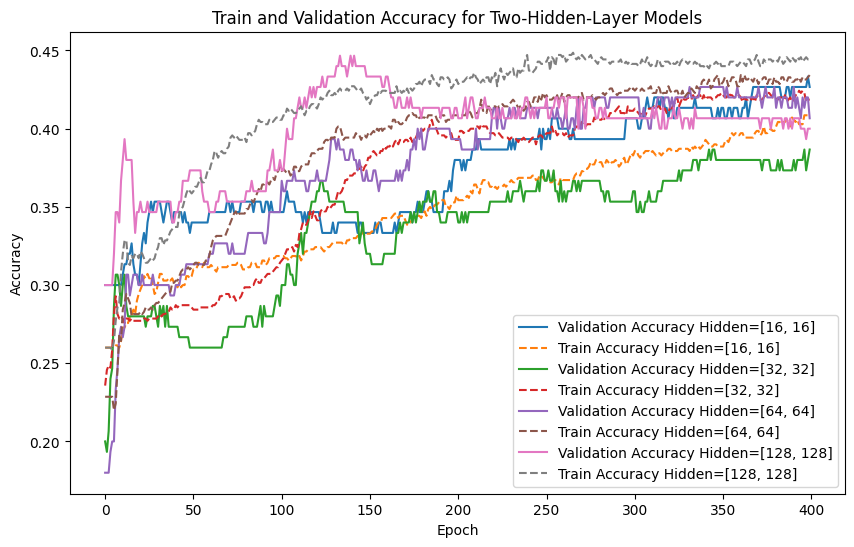

The best model has hidden layer sizes [128, 128] with the lowest validation loss at epoch 262. Validation loss: 1.2625

Classification Report for the Best Model:
              precision    recall  f1-score   support

           0       0.52      0.59      0.55        39
           1       0.35      0.23      0.28        30
           2       0.44      0.50      0.47        44
           3       0.44      0.43      0.44        37

    accuracy                           0.45       150
   macro avg       0.44      0.44      0.44       150
weighted avg       0.44      0.45      0.45       150



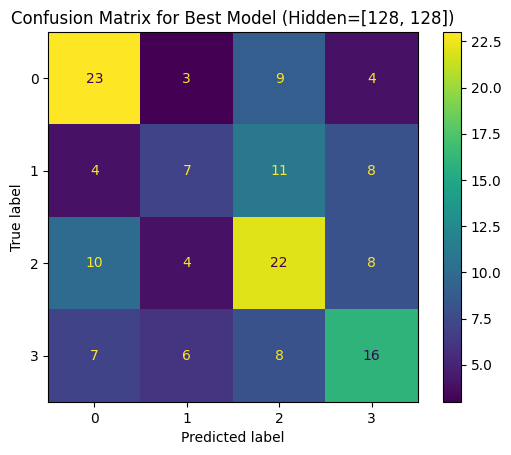

In [20]:
# Define the model with two hidden layers
class TwoHiddenNN(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(TwoHiddenNN, self).__init__()
        self.hidden1 = nn.Linear(input_size, hidden_sizes[0])
        self.hidden2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.output = nn.Linear(hidden_sizes[1], output_size)

    def forward(self, x):
        x = torch.relu(self.hidden1(x))
        x = torch.relu(self.hidden2(x))
        x = self.output(x)
        return x

# Training and evaluation function (same as before)
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs):
    train_loss, val_loss, train_acc, val_acc = [], [], [], []
    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * X_batch.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)
        train_loss.append(running_loss / total)
        train_acc.append(correct / total)

        # Validation phase
        model.eval()
        running_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                running_loss += loss.item() * X_batch.size(0)
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == y_batch).sum().item()
                total += y_batch.size(0)
        val_loss.append(running_loss / total)
        val_acc.append(correct / total)
    return train_loss, val_loss, train_acc, val_acc

# Train models with different hidden layer sizes
input_size = X_train_tensor.shape[1]
output_size = len(y_train.unique())
hidden_layer_configs = [[16, 16], [32, 32], [64, 64], [128, 128]]
epochs = 400
results = []

for hidden_sizes in hidden_layer_configs:
    model = TwoHiddenNN(input_size, hidden_sizes, output_size)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    train_loss, val_loss, train_acc, val_acc = train_model(
        model, train_loader, val_loader, criterion, optimizer, epochs
    )
    results.append({
        "hidden_sizes": hidden_sizes,
        "train_loss": train_loss,
        "val_loss": val_loss,
        "train_acc": train_acc,
        "val_acc": val_acc,
        "model": model
    })

# Save only the last epoch's results to CSV
last_epoch_data = []
for res in results:
    last_epoch_data.append({
        "hidden_sizes": res["hidden_sizes"],
        "train_loss": res["train_loss"][-1],
        "val_loss": res["val_loss"][-1],
        "train_acc": res["train_acc"][-1],
        "val_acc": res["val_acc"][-1],
    })

df_last_epoch = pd.DataFrame(last_epoch_data)
df_last_epoch.to_csv("results_two_hidden_last_epoch.csv", index=False)

# Plot losses and accuracies
plt.figure(figsize=(10, 6))
for res in results:
    label = f"Hidden={res['hidden_sizes']}"
    plt.plot(res["val_loss"], label=f"Validation Loss {label}")
    plt.plot(res["train_loss"], linestyle="--", label=f"Train Loss {label}")
plt.title("Train and Validation Loss for Two-Hidden-Layer Models")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
for res in results:
    label = f"Hidden={res['hidden_sizes']}"
    plt.plot(res["val_acc"], label=f"Validation Accuracy {label}")
    plt.plot(res["train_acc"], linestyle="--", label=f"Train Accuracy {label}")
plt.title("Train and Validation Accuracy for Two-Hidden-Layer Models")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Find the best model based on the minimum validation loss
best_model = min(results, key=lambda x: min(x["val_loss"]))
best_epoch = best_model["val_loss"].index(min(best_model["val_loss"])) + 1
best_hidden_sizes = best_model["hidden_sizes"]

# Print the best model information
print(f"The best model has hidden layer sizes {best_hidden_sizes} with the lowest validation loss "
      f"at epoch {best_epoch}. Validation loss: {min(best_model['val_loss']):.4f}")

# Evaluate the best model on the test set
best_model["model"].eval()
y_true, y_pred = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = best_model["model"](X_batch)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(y_batch.tolist())
        y_pred.extend(predicted.tolist())

# Generate confusion matrix and classification report
cm = confusion_matrix(y_true, y_pred)
print("\nClassification Report for the Best Model:")
print(classification_report(y_true, y_pred))
ConfusionMatrixDisplay(cm).plot()
plt.title(f"Confusion Matrix for Best Model (Hidden={best_hidden_sizes})")
plt.show()

# **One hidden layer with batch norm**

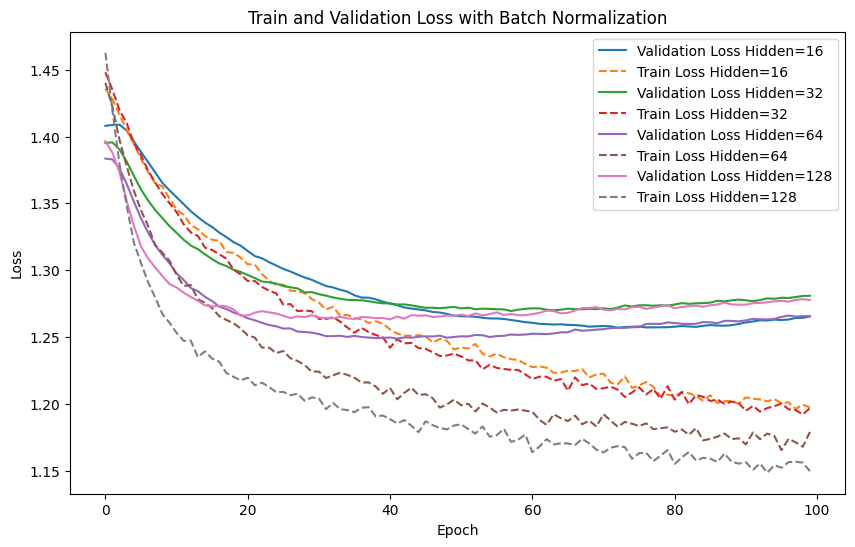

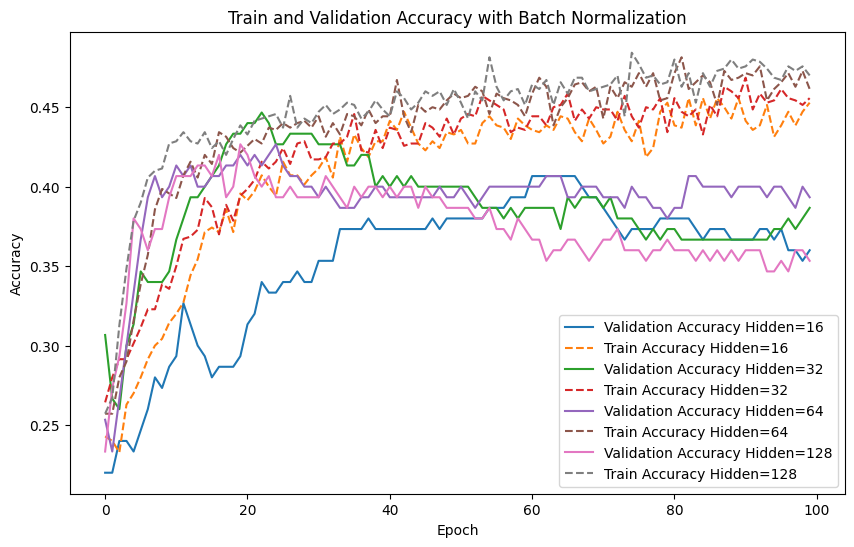

The best model has a hidden layer size of 64 with the lowest validation loss at epoch 42. Validation loss: 1.2489

Classification Report for the Best Model:
              precision    recall  f1-score   support

           0       0.49      0.59      0.53        39
           1       0.14      0.10      0.12        30
           2       0.39      0.41      0.40        44
           3       0.47      0.46      0.47        37

    accuracy                           0.41       150
   macro avg       0.37      0.39      0.38       150
weighted avg       0.39      0.41      0.39       150



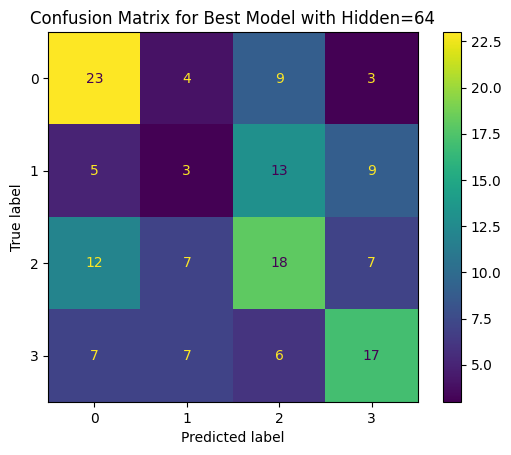

In [21]:
class OneHiddenNNWithBatchNorm(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(OneHiddenNNWithBatchNorm, self).__init__()
        self.hidden = nn.Linear(input_size, hidden_size)  # Hidden layer
        self.batch_norm = nn.BatchNorm1d(hidden_size)    # Batch normalization
        self.output = nn.Linear(hidden_size, output_size)  # Output layer

    def forward(self, x):
        x = self.hidden(x)                # Pass input through hidden layer
        x = self.batch_norm(x)            # Apply batch normalization
        x = torch.relu(x)                 # Apply ReLU activation
        x = self.output(x)                # Pass through output layer
        return x

# Training and evaluation function
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs):
    train_loss, val_loss, train_acc, val_acc = [], [], [], []
    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * X_batch.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)
        train_loss.append(running_loss / total)
        train_acc.append(correct / total)

        # Validation phase
        model.eval()
        running_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                running_loss += loss.item() * X_batch.size(0)
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == y_batch).sum().item()
                total += y_batch.size(0)
        val_loss.append(running_loss / total)
        val_acc.append(correct / total)
    return train_loss, val_loss, train_acc, val_acc

# Train models with different hidden layer sizes
input_size = X_train_tensor.shape[1]
output_size = len(y_train.unique())
hidden_sizes = [16, 32, 64, 128]
epochs = 100
results = []

for hidden_size in hidden_sizes:
    model = OneHiddenNNWithBatchNorm(input_size, hidden_size, output_size)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    train_loss, val_loss, train_acc, val_acc = train_model(
        model, train_loader, val_loader, criterion, optimizer, epochs
    )
    results.append({
        "hidden_size": hidden_size,
        "train_loss": train_loss,
        "val_loss": val_loss,
        "train_acc": train_acc,
        "val_acc": val_acc,
        "model": model
    })

# Save only the last epoch's results to CSV
last_epoch_data = []
for res in results:
    last_epoch_data.append({
        "hidden_size": res["hidden_size"],
        "train_loss": res["train_loss"][-1],
        "val_loss": res["val_loss"][-1],
        "train_acc": res["train_acc"][-1],
        "val_acc": res["val_acc"][-1],
    })

df_last_epoch = pd.DataFrame(last_epoch_data)
df_last_epoch.to_csv("results_batch_norm_last_epoch.csv", index=False)

# Plot losses and accuracies
plt.figure(figsize=(10, 6))
for res in results:
    label = f"Hidden={res['hidden_size']}"
    plt.plot(res["val_loss"], label=f"Validation Loss {label}")
    plt.plot(res["train_loss"], linestyle="--", label=f"Train Loss {label}")
plt.title("Train and Validation Loss with Batch Normalization")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
for res in results:
    label = f"Hidden={res['hidden_size']}"
    plt.plot(res["val_acc"], label=f"Validation Accuracy {label}")
    plt.plot(res["train_acc"], linestyle="--", label=f"Train Accuracy {label}")
plt.title("Train and Validation Accuracy with Batch Normalization")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Find the best model based on the minimum validation loss
best_model = min(results, key=lambda x: min(x["val_loss"]))
best_epoch = best_model["val_loss"].index(min(best_model["val_loss"])) + 1
best_hidden_size = best_model["hidden_size"]

# Print the best model information
print(f"The best model has a hidden layer size of {best_hidden_size} with the lowest validation loss "
      f"at epoch {best_epoch}. Validation loss: {min(best_model['val_loss']):.4f}")

# Evaluate the best model on the test set
best_model["model"].eval()
y_true, y_pred = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = best_model["model"](X_batch)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(y_batch.tolist())
        y_pred.extend(predicted.tolist())

# Generate confusion matrix and classification report
cm = confusion_matrix(y_true, y_pred)
print("\nClassification Report for the Best Model:")
print(classification_report(y_true, y_pred))
ConfusionMatrixDisplay(cm).plot()
plt.title(f"Confusion Matrix for Best Model with Hidden={best_hidden_size}")
plt.show()


# **Model 2 with bn**

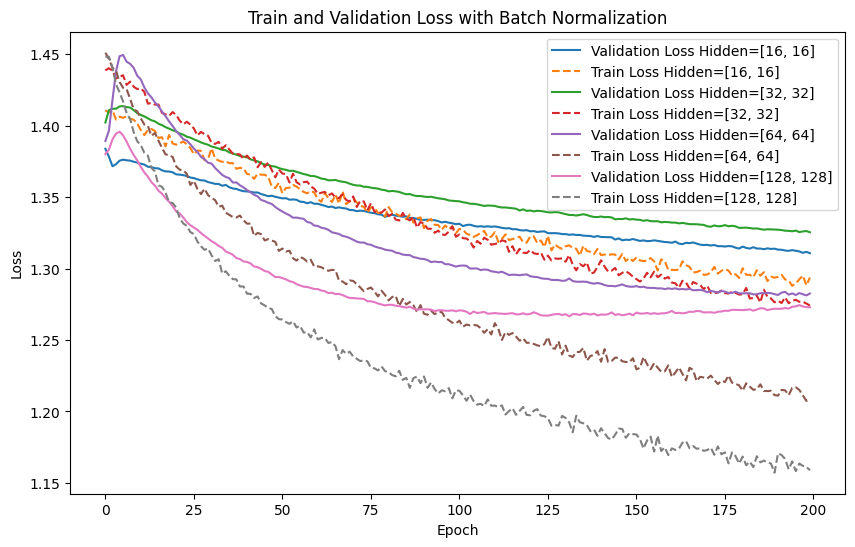

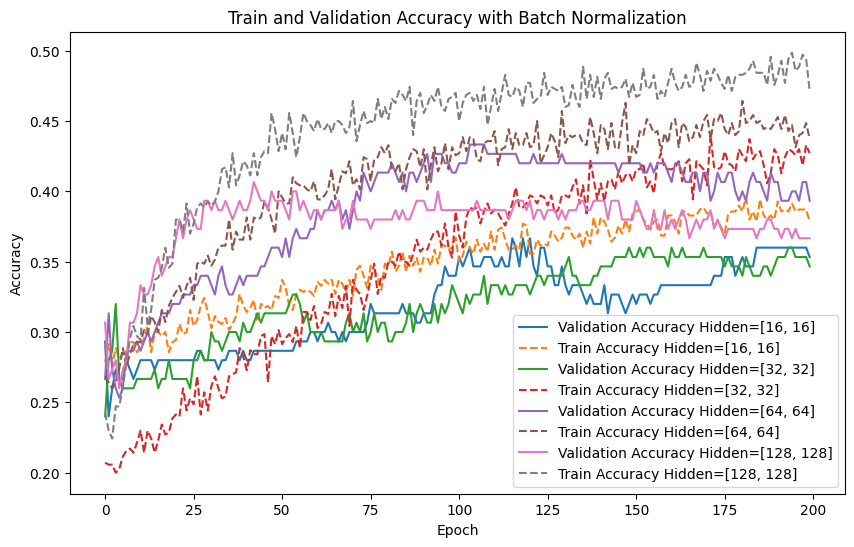

The best model has hidden layer sizes [128, 128] with the lowest validation loss at epoch 132. Validation loss: 1.2666

Classification Report for the Best Model:
              precision    recall  f1-score   support

           0       0.54      0.64      0.59        39
           1       0.17      0.13      0.15        30
           2       0.40      0.43      0.42        44
           3       0.41      0.38      0.39        37

    accuracy                           0.41       150
   macro avg       0.38      0.40      0.39       150
weighted avg       0.40      0.41      0.40       150



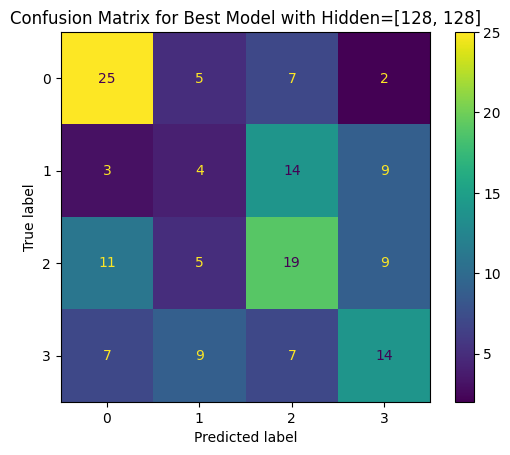

In [22]:
class TwoHiddenNNWithBatchNorm(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(TwoHiddenNNWithBatchNorm, self).__init__()
        self.hidden1 = nn.Linear(input_size, hidden_sizes[0])  # First hidden layer
        self.batch_norm1 = nn.BatchNorm1d(hidden_sizes[0])     # Batch norm for first hidden layer
        self.hidden2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])  # Second hidden layer
        self.batch_norm2 = nn.BatchNorm1d(hidden_sizes[1])     # Batch norm for second hidden layer
        self.output = nn.Linear(hidden_sizes[1], output_size)  # Output layer

    def forward(self, x):
        x = self.hidden1(x)                # Pass input through first hidden layer
        x = self.batch_norm1(x)            # Apply batch normalization
        x = torch.relu(x)                  # Apply ReLU activation
        x = self.hidden2(x)                # Pass through second hidden layer
        x = self.batch_norm2(x)            # Apply batch normalization
        x = torch.relu(x)                  # Apply ReLU activation
        x = self.output(x)                 # Pass through output layer
        return x

# Training and evaluation function
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs):
    train_loss, val_loss, train_acc, val_acc = [], [], [], []
    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * X_batch.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)
        train_loss.append(running_loss / total)
        train_acc.append(correct / total)

        # Validation phase
        model.eval()
        running_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                running_loss += loss.item() * X_batch.size(0)
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == y_batch).sum().item()
                total += y_batch.size(0)
        val_loss.append(running_loss / total)
        val_acc.append(correct / total)
    return train_loss, val_loss, train_acc, val_acc

# Train models with different hidden layer sizes
input_size = X_train_tensor.shape[1]
output_size = len(y_train.unique())
hidden_layer_configs = [[16, 16], [32, 32], [64, 64], [128, 128]]
epochs = 200
results = []

for hidden_sizes in hidden_layer_configs:
    model = TwoHiddenNNWithBatchNorm(input_size, hidden_sizes, output_size)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
    train_loss, val_loss, train_acc, val_acc = train_model(
        model, train_loader, val_loader, criterion, optimizer, epochs
    )
    results.append({
        "hidden_sizes": hidden_sizes,
        "train_loss": train_loss,
        "val_loss": val_loss,
        "train_acc": train_acc,
        "val_acc": val_acc,
        "model": model
    })

# Save only the last epoch's results to CSV
last_epoch_data = []
for res in results:
    last_epoch_data.append({
        "hidden_sizes": res["hidden_sizes"],
        "train_loss": res["train_loss"][-1],
        "val_loss": res["val_loss"][-1],
        "train_acc": res["train_acc"][-1],
        "val_acc": res["val_acc"][-1],
    })

df_last_epoch = pd.DataFrame(last_epoch_data)
df_last_epoch.to_csv("results_two_hidden_batch_norm_last_epoch.csv", index=False)

# Plot losses and accuracies
plt.figure(figsize=(10, 6))
for res in results:
    label = f"Hidden={res['hidden_sizes']}"
    plt.plot(res["val_loss"], label=f"Validation Loss {label}")
    plt.plot(res["train_loss"], linestyle="--", label=f"Train Loss {label}")
plt.title("Train and Validation Loss with Batch Normalization")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
for res in results:
    label = f"Hidden={res['hidden_sizes']}"
    plt.plot(res["val_acc"], label=f"Validation Accuracy {label}")
    plt.plot(res["train_acc"], linestyle="--", label=f"Train Accuracy {label}")
plt.title("Train and Validation Accuracy with Batch Normalization")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Find the best model based on the minimum validation loss
best_model = min(results, key=lambda x: min(x["val_loss"]))
best_epoch = best_model["val_loss"].index(min(best_model["val_loss"])) + 1
best_hidden_sizes = best_model["hidden_sizes"]

# Print the best model information
print(f"The best model has hidden layer sizes {best_hidden_sizes} with the lowest validation loss "
      f"at epoch {best_epoch}. Validation loss: {min(best_model['val_loss']):.4f}")

# Evaluate the best model on the test set
best_model["model"].eval()
y_true, y_pred = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = best_model["model"](X_batch)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(y_batch.tolist())
        y_pred.extend(predicted.tolist())

# Generate confusion matrix and classification report
cm = confusion_matrix(y_true, y_pred)
print("\nClassification Report for the Best Model:")
print(classification_report(y_true, y_pred))
ConfusionMatrixDisplay(cm).plot()
plt.title(f"Confusion Matrix for Best Model with Hidden={best_hidden_sizes}")
plt.show()


## Drop out

# **Model 1**

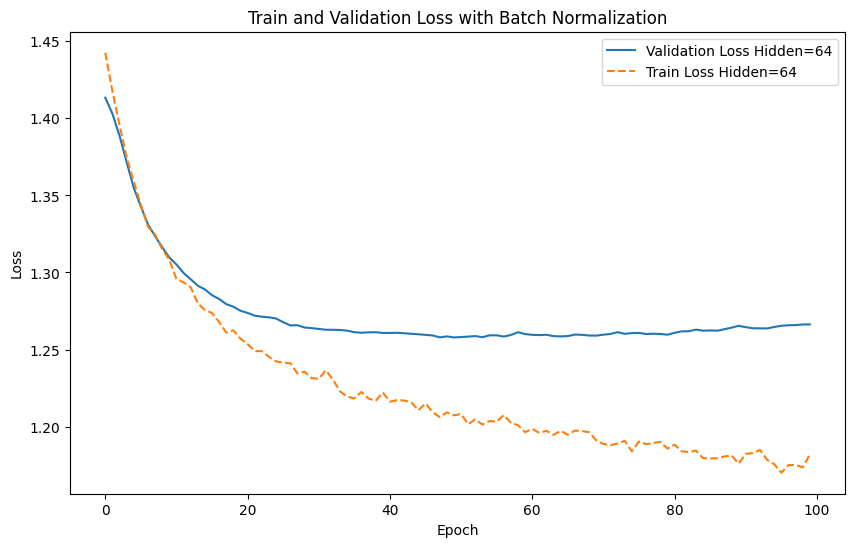

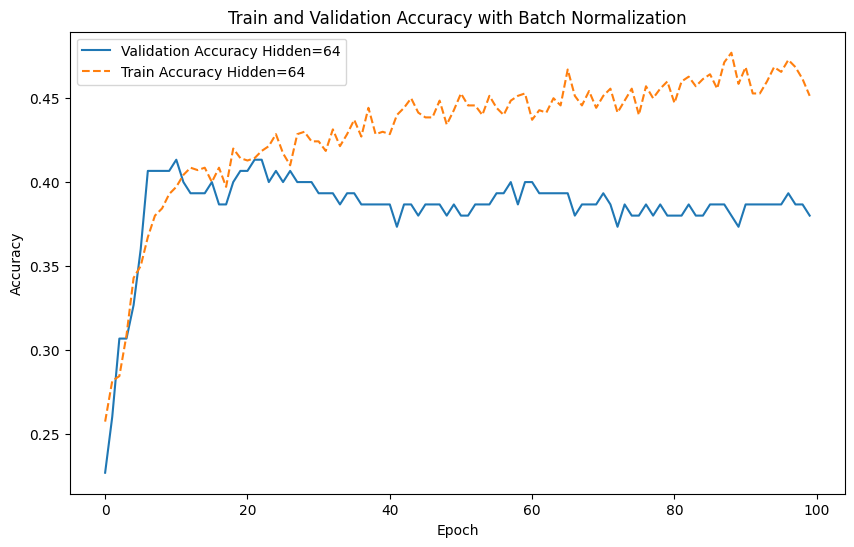

The best model has a hidden layer size of 64 with the lowest validation loss at epoch 50. Validation loss: 1.2578

Classification Report for the Best Model:
              precision    recall  f1-score   support

           0       0.47      0.54      0.50        39
           1       0.36      0.27      0.31        30
           2       0.40      0.45      0.43        44
           3       0.42      0.38      0.40        37

    accuracy                           0.42       150
   macro avg       0.41      0.41      0.41       150
weighted avg       0.42      0.42      0.42       150



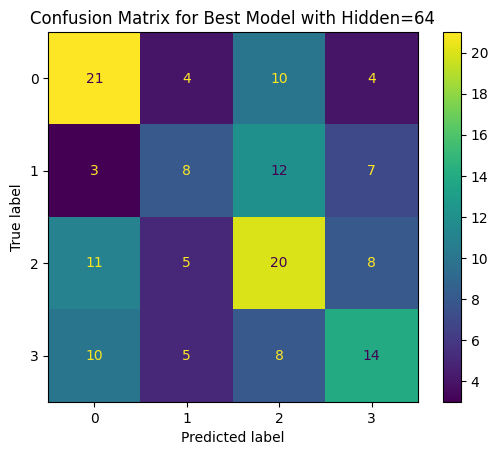

In [28]:
import torch
import torch.nn as nn

class OneHiddenNNWithBatchNormAndDropout(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_prob=0.3):
        super(OneHiddenNNWithBatchNormAndDropout, self).__init__()
        self.hidden = nn.Linear(input_size, hidden_size)  # Hidden layer
        self.batch_norm = nn.BatchNorm1d(hidden_size)    # Batch normalization
        self.dropout = nn.Dropout(dropout_prob)          # Dropout layer
        self.output = nn.Linear(hidden_size, output_size)  # Output layer

    def forward(self, x):
        x = self.hidden(x)                # Pass input through hidden layer
        x = self.batch_norm(x)            # Apply batch normalization
        x = torch.relu(x)                 # Apply ReLU activation
        x = self.dropout(x)               # Apply dropout
        x = self.output(x)                # Pass through output layer
        return x


# Training and evaluation function
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs):
    train_loss, val_loss, train_acc, val_acc = [], [], [], []
    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * X_batch.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)
        train_loss.append(running_loss / total)
        train_acc.append(correct / total)

        # Validation phase
        model.eval()
        running_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                running_loss += loss.item() * X_batch.size(0)
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == y_batch).sum().item()
                total += y_batch.size(0)
        val_loss.append(running_loss / total)
        val_acc.append(correct / total)
    return train_loss, val_loss, train_acc, val_acc

# Train models with different hidden layer sizes
input_size = X_train_tensor.shape[1]
output_size = len(y_train.unique())
hidden_sizes = [64]
epochs = 100
results = []

for hidden_size in hidden_sizes:
    model = OneHiddenNNWithBatchNorm(input_size, hidden_size, output_size)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    train_loss, val_loss, train_acc, val_acc = train_model(
        model, train_loader, val_loader, criterion, optimizer, epochs
    )
    results.append({
        "hidden_size": hidden_size,
        "train_loss": train_loss,
        "val_loss": val_loss,
        "train_acc": train_acc,
        "val_acc": val_acc,
        "model": model
    })

# Save only the last epoch's results to CSV
last_epoch_data = []
for res in results:
    last_epoch_data.append({
        "hidden_size": res["hidden_size"],
        "train_loss": res["train_loss"][-1],
        "val_loss": res["val_loss"][-1],
        "train_acc": res["train_acc"][-1],
        "val_acc": res["val_acc"][-1],
    })

df_last_epoch = pd.DataFrame(last_epoch_data)
df_last_epoch.to_csv("results_batch_norm_last_epoch.csv", index=False)

# Plot losses and accuracies
plt.figure(figsize=(10, 6))
for res in results:
    label = f"Hidden={res['hidden_size']}"
    plt.plot(res["val_loss"], label=f"Validation Loss {label}")
    plt.plot(res["train_loss"], linestyle="--", label=f"Train Loss {label}")
plt.title("Train and Validation Loss with Batch Normalization")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
for res in results:
    label = f"Hidden={res['hidden_size']}"
    plt.plot(res["val_acc"], label=f"Validation Accuracy {label}")
    plt.plot(res["train_acc"], linestyle="--", label=f"Train Accuracy {label}")
plt.title("Train and Validation Accuracy with Batch Normalization")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Find the best model based on the minimum validation loss
best_model = min(results, key=lambda x: min(x["val_loss"]))
best_epoch = best_model["val_loss"].index(min(best_model["val_loss"])) + 1
best_hidden_size = best_model["hidden_size"]

# Print the best model information
print(f"The best model has a hidden layer size of {best_hidden_size} with the lowest validation loss "
      f"at epoch {best_epoch}. Validation loss: {min(best_model['val_loss']):.4f}")

# Evaluate the best model on the test set
best_model["model"].eval()
y_true, y_pred = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = best_model["model"](X_batch)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(y_batch.tolist())
        y_pred.extend(predicted.tolist())

# Generate confusion matrix and classification report
cm = confusion_matrix(y_true, y_pred)
print("\nClassification Report for the Best Model:")
print(classification_report(y_true, y_pred))
ConfusionMatrixDisplay(cm).plot()
plt.title(f"Confusion Matrix for Best Model with Hidden={best_hidden_size}")
plt.show()


# **Model 2**

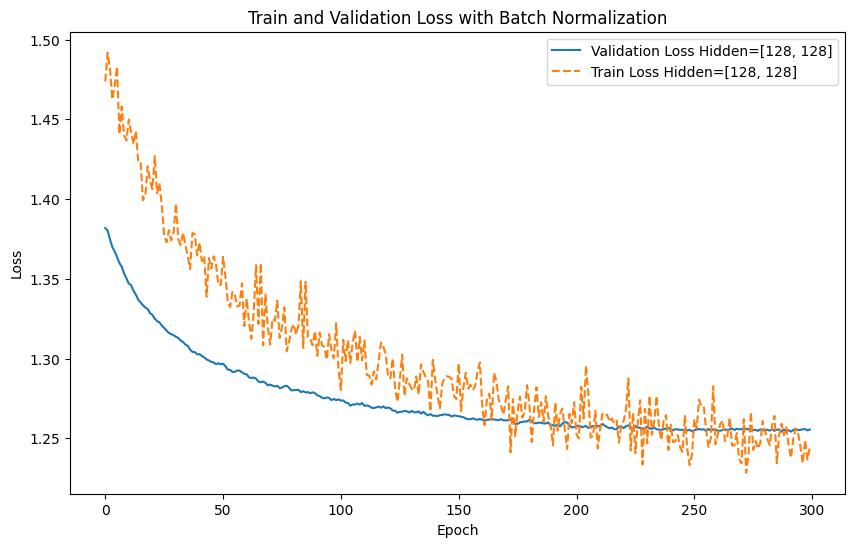

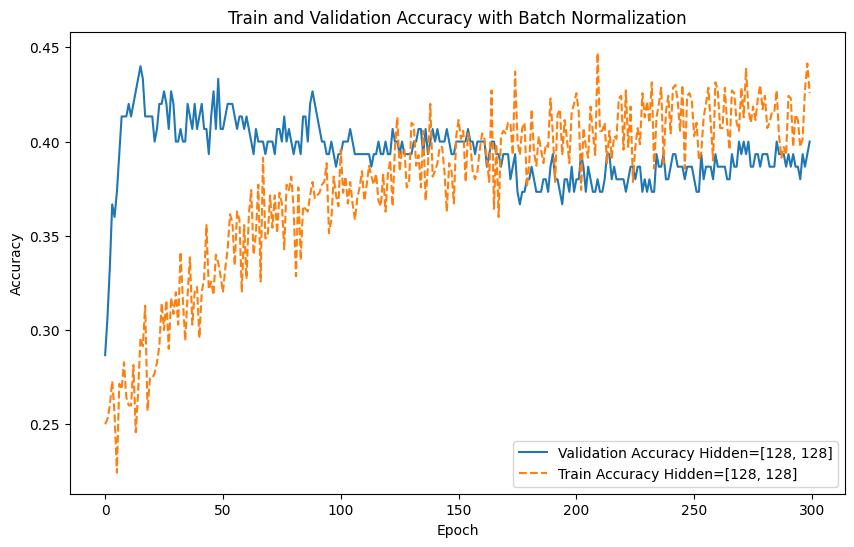

The best model has hidden layer sizes [128, 128] with the lowest validation loss at epoch 288. Validation loss: 1.2542

Classification Report for the Best Model:
              precision    recall  f1-score   support

           0       0.45      0.56      0.50        39
           1       0.24      0.17      0.20        30
           2       0.41      0.45      0.43        44
           3       0.42      0.35      0.38        37

    accuracy                           0.40       150
   macro avg       0.38      0.38      0.38       150
weighted avg       0.39      0.40      0.39       150



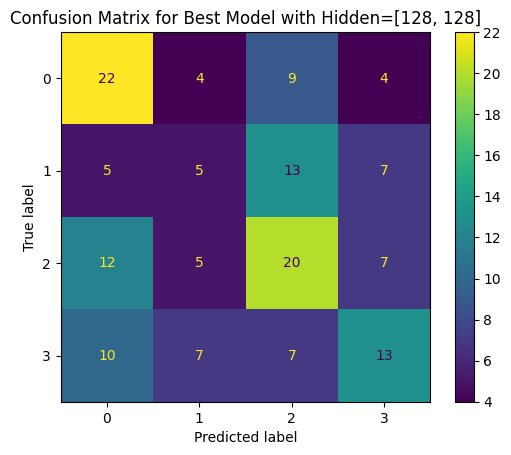

In [31]:
class TwoHiddenNNWithBatchNorm(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size,dropout_prob=0.3):
        super(TwoHiddenNNWithBatchNorm, self).__init__()
        self.hidden1 = nn.Linear(input_size, hidden_sizes[0])  # First hidden layer
        self.batch_norm1 = nn.BatchNorm1d(hidden_sizes[0])     # Batch norm for first hidden layer
        self.hidden2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])  # Second hidden layer
        self.batch_norm2 = nn.BatchNorm1d(hidden_sizes[1])     # Batch norm for second hidden layer
        self.dropout = nn.Dropout(dropout_prob)          # Dropout layer
        self.output = nn.Linear(hidden_sizes[1], output_size)  # Output layer

    def forward(self, x):
        x = self.hidden1(x)                # Pass input through first hidden layer
        x = self.batch_norm1(x)            # Apply batch normalization
        x = torch.relu(x)                  # Apply ReLU activation
        x = self.dropout(x)               # Apply dropout
        x = self.hidden2(x)                # Pass through second hidden layer
        x = self.batch_norm2(x)            # Apply batch normalization
        x = torch.relu(x)                  # Apply ReLU activation
        x = self.dropout(x)               # Apply dropout
        x = self.output(x)                 # Pass through output layer
        return x

# Training and evaluation function
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs):
    train_loss, val_loss, train_acc, val_acc = [], [], [], []
    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * X_batch.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)
        train_loss.append(running_loss / total)
        train_acc.append(correct / total)

        # Validation phase
        model.eval()
        running_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                running_loss += loss.item() * X_batch.size(0)
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == y_batch).sum().item()
                total += y_batch.size(0)
        val_loss.append(running_loss / total)
        val_acc.append(correct / total)
    return train_loss, val_loss, train_acc, val_acc

# Train models with different hidden layer sizes
input_size = X_train_tensor.shape[1]
output_size = len(y_train.unique())
hidden_layer_configs = [[128, 128]]
epochs = 300
results = []

for hidden_sizes in hidden_layer_configs:
    model = TwoHiddenNNWithBatchNorm(input_size, hidden_sizes, output_size)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
    train_loss, val_loss, train_acc, val_acc = train_model(
        model, train_loader, val_loader, criterion, optimizer, epochs
    )
    results.append({
        "hidden_sizes": hidden_sizes,
        "train_loss": train_loss,
        "val_loss": val_loss,
        "train_acc": train_acc,
        "val_acc": val_acc,
        "model": model
    })

# Save only the last epoch's results to CSV
last_epoch_data = []
for res in results:
    last_epoch_data.append({
        "hidden_sizes": res["hidden_sizes"],
        "train_loss": res["train_loss"][-1],
        "val_loss": res["val_loss"][-1],
        "train_acc": res["train_acc"][-1],
        "val_acc": res["val_acc"][-1],
    })

df_last_epoch = pd.DataFrame(last_epoch_data)
df_last_epoch.to_csv("results_two_hidden_batch_norm_last_epoch.csv", index=False)

# Plot losses and accuracies
plt.figure(figsize=(10, 6))
for res in results:
    label = f"Hidden={res['hidden_sizes']}"
    plt.plot(res["val_loss"], label=f"Validation Loss {label}")
    plt.plot(res["train_loss"], linestyle="--", label=f"Train Loss {label}")
plt.title("Train and Validation Loss with Batch Normalization")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
for res in results:
    label = f"Hidden={res['hidden_sizes']}"
    plt.plot(res["val_acc"], label=f"Validation Accuracy {label}")
    plt.plot(res["train_acc"], linestyle="--", label=f"Train Accuracy {label}")
plt.title("Train and Validation Accuracy with Batch Normalization")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Find the best model based on the minimum validation loss
best_model = min(results, key=lambda x: min(x["val_loss"]))
best_epoch = best_model["val_loss"].index(min(best_model["val_loss"])) + 1
best_hidden_sizes = best_model["hidden_sizes"]

# Print the best model information
print(f"The best model has hidden layer sizes {best_hidden_sizes} with the lowest validation loss "
      f"at epoch {best_epoch}. Validation loss: {min(best_model['val_loss']):.4f}")

# Evaluate the best model on the test set
best_model["model"].eval()
y_true, y_pred = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = best_model["model"](X_batch)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(y_batch.tolist())
        y_pred.extend(predicted.tolist())

# Generate confusion matrix and classification report
cm = confusion_matrix(y_true, y_pred)
print("\nClassification Report for the Best Model:")
print(classification_report(y_true, y_pred))
ConfusionMatrixDisplay(cm).plot()
plt.title(f"Confusion Matrix for Best Model with Hidden={best_hidden_sizes}")
plt.show()


# **Adding L2**

# **Model 1**

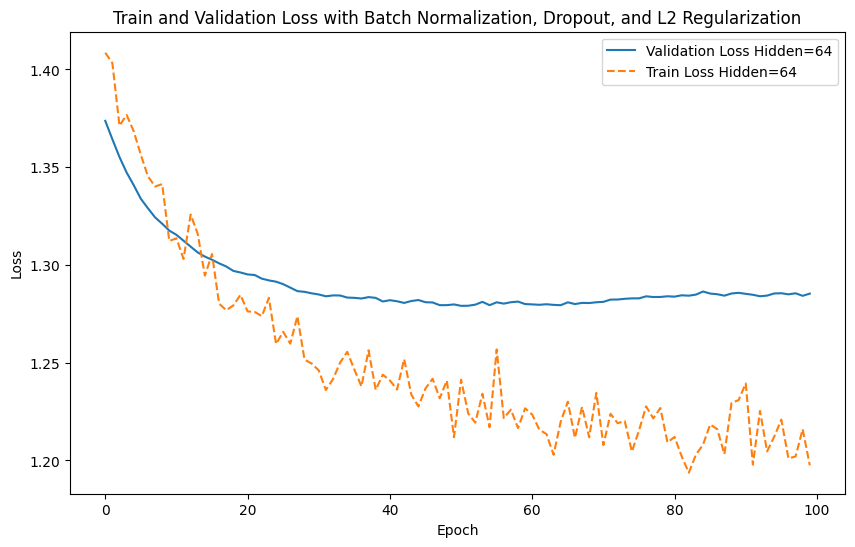

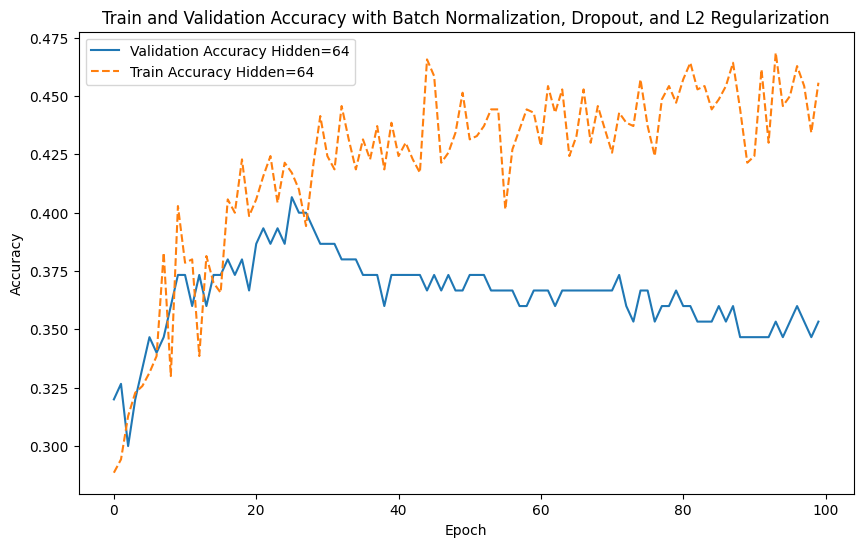

The best model has a hidden layer size of 64 with the lowest validation loss at epoch 51. Validation loss: 1.2791

Classification Report for the Best Model:
              precision    recall  f1-score   support

           0       0.47      0.49      0.48        39
           1       0.29      0.20      0.24        30
           2       0.38      0.50      0.43        44
           3       0.45      0.38      0.41        37

    accuracy                           0.41       150
   macro avg       0.40      0.39      0.39       150
weighted avg       0.40      0.41      0.40       150



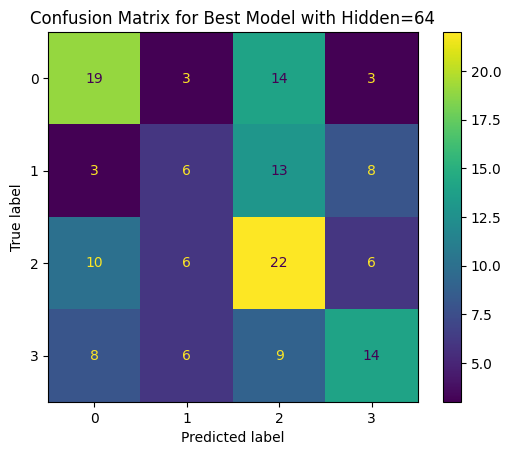

In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

class OneHiddenNNWithBatchNormAndDropout(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_prob=0.3):
        super(OneHiddenNNWithBatchNormAndDropout, self).__init__()
        self.hidden = nn.Linear(input_size, hidden_size)  # Hidden layer
        self.batch_norm = nn.BatchNorm1d(hidden_size)    # Batch normalization
        self.dropout = nn.Dropout(dropout_prob)          # Dropout layer
        self.output = nn.Linear(hidden_size, output_size)  # Output layer

    def forward(self, x):
        x = self.hidden(x)                # Pass input through hidden layer
        x = self.batch_norm(x)            # Apply batch normalization
        x = torch.relu(x)                 # Apply ReLU activation
        x = self.dropout(x)               # Apply dropout
        x = self.output(x)                # Pass through output layer
        return x

# Training and evaluation function
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs):
    train_loss, val_loss, train_acc, val_acc = [], [], [], []
    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * X_batch.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)
        train_loss.append(running_loss / total)
        train_acc.append(correct / total)

        # Validation phase
        model.eval()
        running_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                running_loss += loss.item() * X_batch.size(0)
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == y_batch).sum().item()
                total += y_batch.size(0)
        val_loss.append(running_loss / total)
        val_acc.append(correct / total)
    return train_loss, val_loss, train_acc, val_acc

# Train models with different hidden layer sizes
input_size = X_train_tensor.shape[1]
output_size = len(y_train.unique())
hidden_sizes = [64]
epochs = 100
results = []

for hidden_size in hidden_sizes:
    model = OneHiddenNNWithBatchNormAndDropout(input_size, hidden_size, output_size, dropout_prob=0.3)
    criterion = nn.CrossEntropyLoss()

    # Add L2 regularization (weight_decay)
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0001)

    train_loss, val_loss, train_acc, val_acc = train_model(
        model, train_loader, val_loader, criterion, optimizer, epochs
    )
    results.append({
        "hidden_size": hidden_size,
        "train_loss": train_loss,
        "val_loss": val_loss,
        "train_acc": train_acc,
        "val_acc": val_acc,
        "model": model
    })

# Save only the last epoch's results to CSV
last_epoch_data = []
for res in results:
    last_epoch_data.append({
        "hidden_size": res["hidden_size"],
        "train_loss": res["train_loss"][-1],
        "val_loss": res["val_loss"][-1],
        "train_acc": res["train_acc"][-1],
        "val_acc": res["val_acc"][-1],
    })

df_last_epoch = pd.DataFrame(last_epoch_data)
df_last_epoch.to_csv("results_batch_norm_last_epoch.csv", index=False)

# Plot losses and accuracies
plt.figure(figsize=(10, 6))
for res in results:
    label = f"Hidden={res['hidden_size']}"
    plt.plot(res["val_loss"], label=f"Validation Loss {label}")
    plt.plot(res["train_loss"], linestyle="--", label=f"Train Loss {label}")
plt.title("Train and Validation Loss with Batch Normalization, Dropout, and L2 Regularization")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
for res in results:
    label = f"Hidden={res['hidden_size']}"
    plt.plot(res["val_acc"], label=f"Validation Accuracy {label}")
    plt.plot(res["train_acc"], linestyle="--", label=f"Train Accuracy {label}")
plt.title("Train and Validation Accuracy with Batch Normalization, Dropout, and L2 Regularization")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Find the best model based on the minimum validation loss
best_model = min(results, key=lambda x: min(x["val_loss"]))
best_epoch = best_model["val_loss"].index(min(best_model["val_loss"])) + 1
best_hidden_size = best_model["hidden_size"]

# Print the best model information
print(f"The best model has a hidden layer size of {best_hidden_size} with the lowest validation loss "
      f"at epoch {best_epoch}. Validation loss: {min(best_model['val_loss']):.4f}")

# Evaluate the best model on the test set
best_model["model"].eval()
y_true, y_pred = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = best_model["model"](X_batch)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(y_batch.tolist())
        y_pred.extend(predicted.tolist())

# Generate confusion matrix and classification report
cm = confusion_matrix(y_true, y_pred)
print("\nClassification Report for the Best Model:")
print(classification_report(y_true, y_pred))
ConfusionMatrixDisplay(cm).plot()
plt.title(f"Confusion Matrix for Best Model with Hidden={best_hidden_size}")
plt.show()


# **Model 2**

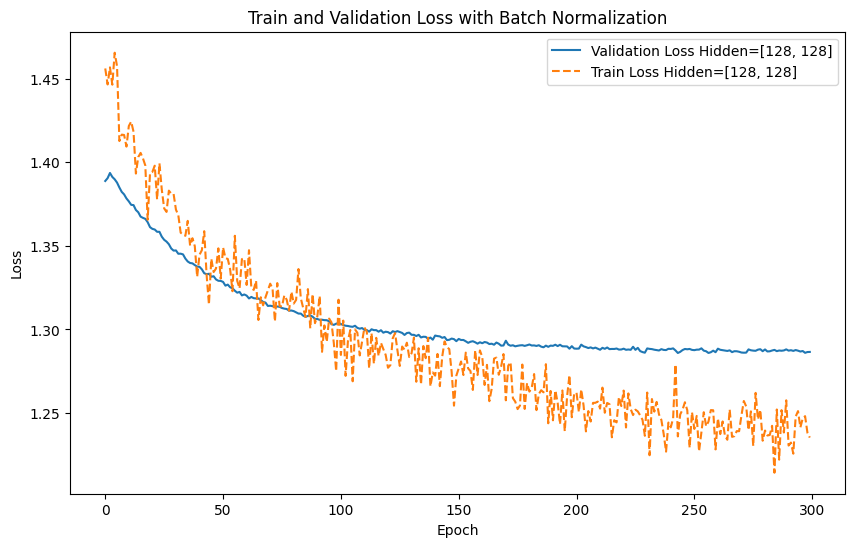

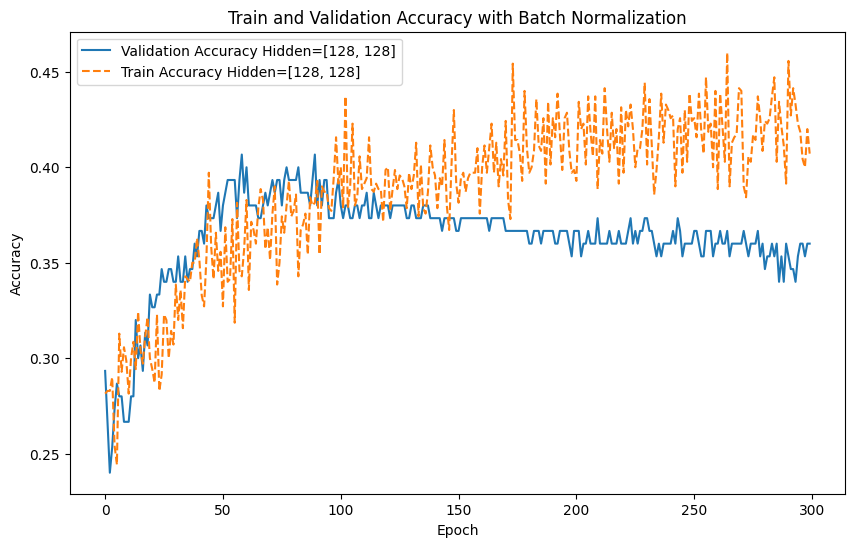

The best model has hidden layer sizes [128, 128] with the lowest validation loss at epoch 244. Validation loss: 1.2859

Classification Report for the Best Model:
              precision    recall  f1-score   support

           0       0.47      0.59      0.52        39
           1       0.13      0.07      0.09        30
           2       0.38      0.45      0.41        44
           3       0.36      0.32      0.34        37

    accuracy                           0.38       150
   macro avg       0.34      0.36      0.34       150
weighted avg       0.35      0.38      0.36       150



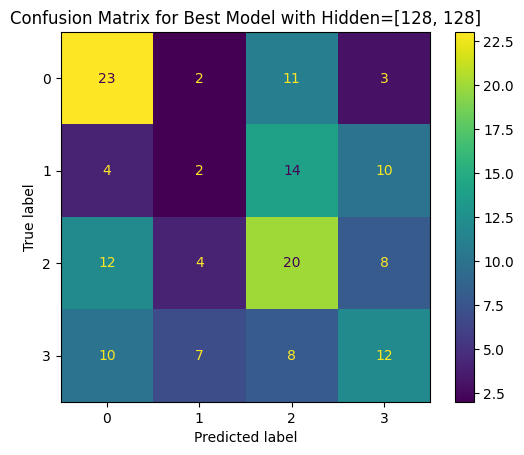

In [39]:
class TwoHiddenNNWithBatchNorm(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size,dropout_prob=0.3):
        super(TwoHiddenNNWithBatchNorm, self).__init__()
        self.hidden1 = nn.Linear(input_size, hidden_sizes[0])  # First hidden layer
        self.batch_norm1 = nn.BatchNorm1d(hidden_sizes[0])     # Batch norm for first hidden layer
        self.hidden2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])  # Second hidden layer
        self.batch_norm2 = nn.BatchNorm1d(hidden_sizes[1])     # Batch norm for second hidden layer
        self.dropout = nn.Dropout(dropout_prob)          # Dropout layer
        self.output = nn.Linear(hidden_sizes[1], output_size)  # Output layer

    def forward(self, x):
        x = self.hidden1(x)                # Pass input through first hidden layer
        x = self.batch_norm1(x)            # Apply batch normalization
        x = torch.relu(x)                  # Apply ReLU activation
        x = self.dropout(x)               # Apply dropout
        x = self.hidden2(x)                # Pass through second hidden layer
        x = self.batch_norm2(x)            # Apply batch normalization
        x = torch.relu(x)                  # Apply ReLU activation
        x = self.dropout(x)               # Apply dropout
        x = self.output(x)                 # Pass through output layer
        return x

# Training and evaluation function
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs):
    train_loss, val_loss, train_acc, val_acc = [], [], [], []
    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * X_batch.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)
        train_loss.append(running_loss / total)
        train_acc.append(correct / total)

        # Validation phase
        model.eval()
        running_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                running_loss += loss.item() * X_batch.size(0)
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == y_batch).sum().item()
                total += y_batch.size(0)
        val_loss.append(running_loss / total)
        val_acc.append(correct / total)
    return train_loss, val_loss, train_acc, val_acc

# Train models with different hidden layer sizes
input_size = X_train_tensor.shape[1]
output_size = len(y_train.unique())
hidden_layer_configs = [[128, 128]]
epochs = 300
results = []

for hidden_sizes in hidden_layer_configs:
    model = TwoHiddenNNWithBatchNorm(input_size, hidden_sizes, output_size)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9,  weight_decay=0.0001)
    train_loss, val_loss, train_acc, val_acc = train_model(
        model, train_loader, val_loader, criterion, optimizer, epochs
    )
    results.append({
        "hidden_sizes": hidden_sizes,
        "train_loss": train_loss,
        "val_loss": val_loss,
        "train_acc": train_acc,
        "val_acc": val_acc,
        "model": model
    })

# Save only the last epoch's results to CSV
last_epoch_data = []
for res in results:
    last_epoch_data.append({
        "hidden_sizes": res["hidden_sizes"],
        "train_loss": res["train_loss"][-1],
        "val_loss": res["val_loss"][-1],
        "train_acc": res["train_acc"][-1],
        "val_acc": res["val_acc"][-1],
    })

df_last_epoch = pd.DataFrame(last_epoch_data)
df_last_epoch.to_csv("results_two_hidden_batch_norm_last_epoch.csv", index=False)

# Plot losses and accuracies
plt.figure(figsize=(10, 6))
for res in results:
    label = f"Hidden={res['hidden_sizes']}"
    plt.plot(res["val_loss"], label=f"Validation Loss {label}")
    plt.plot(res["train_loss"], linestyle="--", label=f"Train Loss {label}")
plt.title("Train and Validation Loss with Batch Normalization")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
for res in results:
    label = f"Hidden={res['hidden_sizes']}"
    plt.plot(res["val_acc"], label=f"Validation Accuracy {label}")
    plt.plot(res["train_acc"], linestyle="--", label=f"Train Accuracy {label}")
plt.title("Train and Validation Accuracy with Batch Normalization")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Find the best model based on the minimum validation loss
best_model = min(results, key=lambda x: min(x["val_loss"]))
best_epoch = best_model["val_loss"].index(min(best_model["val_loss"])) + 1
best_hidden_sizes = best_model["hidden_sizes"]

# Print the best model information
print(f"The best model has hidden layer sizes {best_hidden_sizes} with the lowest validation loss "
      f"at epoch {best_epoch}. Validation loss: {min(best_model['val_loss']):.4f}")

# Evaluate the best model on the test set
best_model["model"].eval()
y_true, y_pred = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = best_model["model"](X_batch)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(y_batch.tolist())
        y_pred.extend(predicted.tolist())

# Generate confusion matrix and classification report
cm = confusion_matrix(y_true, y_pred)
print("\nClassification Report for the Best Model:")
print(classification_report(y_true, y_pred))
ConfusionMatrixDisplay(cm).plot()
plt.title(f"Confusion Matrix for Best Model with Hidden={best_hidden_sizes}")
plt.show()


# **Using ADAOPT**

In [40]:
pip install torch-adopt

In [41]:
from adopt import ADOPT
# optimizer = Adam(model.parameters(), lr=1e-3)
optimizer = ADOPT(model.parameters(), lr=1e-3)

## Model 1

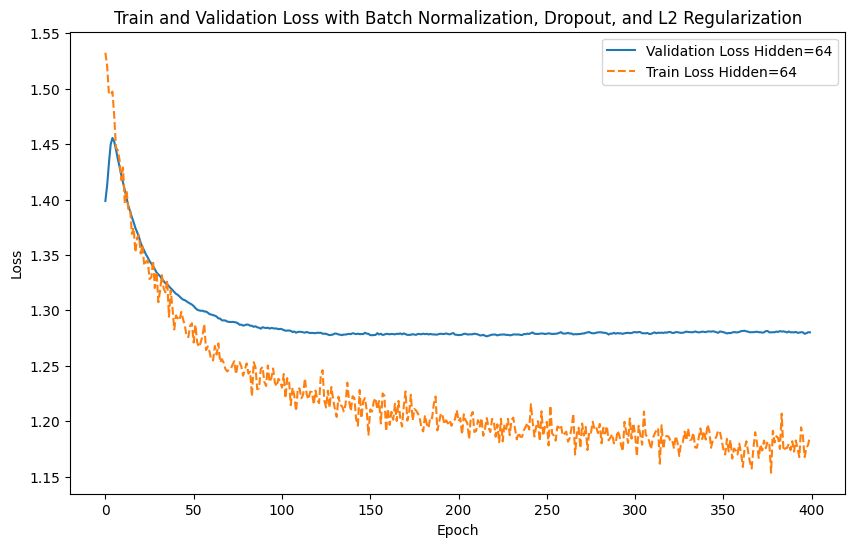

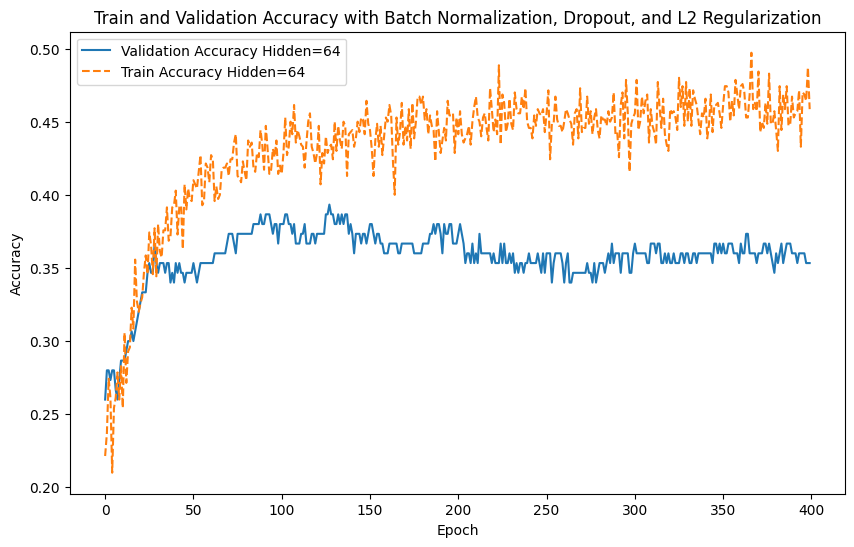

The best model has a hidden layer size of 64 with the lowest validation loss at epoch 217. Validation loss: 1.2766

Classification Report for the Best Model:
              precision    recall  f1-score   support

           0       0.49      0.59      0.53        39
           1       0.29      0.23      0.26        30
           2       0.42      0.48      0.45        44
           3       0.41      0.32      0.36        37

    accuracy                           0.42       150
   macro avg       0.40      0.41      0.40       150
weighted avg       0.41      0.42      0.41       150



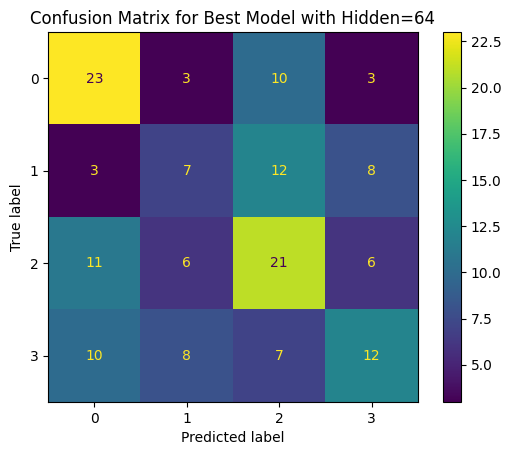

In [74]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

class OneHiddenNNWithBatchNormAndDropout(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_prob=0.2, leaky_slope=0.01):
        super(OneHiddenNNWithBatchNormAndDropout, self).__init__()
        self.hidden = nn.Linear(input_size, hidden_size)  # Hidden layer
        self.batch_norm = nn.BatchNorm1d(hidden_size)     # Batch normalization
        self.dropout = nn.Dropout(dropout_prob)          # Dropout layer
        self.leaky_relu = nn.LeakyReLU(negative_slope=leaky_slope)  # Leaky ReLU activation
        self.output = nn.Linear(hidden_size, output_size)  # Output layer

    def forward(self, x):
        x = self.hidden(x)                # Pass input through hidden layer
        x = self.batch_norm(x)            # Apply batch normalization
        x = self.leaky_relu(x)            # Apply Leaky ReLU activation
        x = self.dropout(x)               # Apply dropout
        x = self.output(x)                # Pass through output layer
        return x

# Training and evaluation function
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs):
    train_loss, val_loss, train_acc, val_acc = [], [], [], []
    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * X_batch.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)
        train_loss.append(running_loss / total)
        train_acc.append(correct / total)

        # Validation phase
        model.eval()
        running_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                running_loss += loss.item() * X_batch.size(0)
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == y_batch).sum().item()
                total += y_batch.size(0)
        val_loss.append(running_loss / total)
        val_acc.append(correct / total)
    return train_loss, val_loss, train_acc, val_acc

# Train models with different hidden layer sizes
input_size = X_train_tensor.shape[1]
output_size = len(y_train.unique())
hidden_sizes = [64]
epochs = 400
results = []

for hidden_size in hidden_sizes:
    model = OneHiddenNNWithBatchNormAndDropout(input_size, hidden_size, output_size, dropout_prob=0.3)
    criterion = nn.CrossEntropyLoss()

    # Add L2 regularization (weight_decay)
    optimizer =  ADOPT(model.parameters(), lr=1e-4)

    train_loss, val_loss, train_acc, val_acc = train_model(
        model, train_loader, val_loader, criterion, optimizer, epochs
    )
    results.append({
        "hidden_size": hidden_size,
        "train_loss": train_loss,
        "val_loss": val_loss,
        "train_acc": train_acc,
        "val_acc": val_acc,
        "model": model
    })

# Save only the last epoch's results to CSV
last_epoch_data = []
for res in results:
    last_epoch_data.append({
        "hidden_size": res["hidden_size"],
        "train_loss": res["train_loss"][-1],
        "val_loss": res["val_loss"][-1],
        "train_acc": res["train_acc"][-1],
        "val_acc": res["val_acc"][-1],
    })

df_last_epoch = pd.DataFrame(last_epoch_data)
df_last_epoch.to_csv("results_batch_norm_last_epoch.csv", index=False)

# Plot losses and accuracies
plt.figure(figsize=(10, 6))
for res in results:
    label = f"Hidden={res['hidden_size']}"
    plt.plot(res["val_loss"], label=f"Validation Loss {label}")
    plt.plot(res["train_loss"], linestyle="--", label=f"Train Loss {label}")
plt.title("Train and Validation Loss with Batch Normalization, Dropout, and L2 Regularization")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
for res in results:
    label = f"Hidden={res['hidden_size']}"
    plt.plot(res["val_acc"], label=f"Validation Accuracy {label}")
    plt.plot(res["train_acc"], linestyle="--", label=f"Train Accuracy {label}")
plt.title("Train and Validation Accuracy with Batch Normalization, Dropout, and L2 Regularization")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Find the best model based on the minimum validation loss
best_model = min(results, key=lambda x: min(x["val_loss"]))
best_epoch = best_model["val_loss"].index(min(best_model["val_loss"])) + 1
best_hidden_size = best_model["hidden_size"]

# Print the best model information
print(f"The best model has a hidden layer size of {best_hidden_size} with the lowest validation loss "
      f"at epoch {best_epoch}. Validation loss: {min(best_model['val_loss']):.4f}")

# Evaluate the best model on the test set
best_model["model"].eval()
y_true, y_pred = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = best_model["model"](X_batch)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(y_batch.tolist())
        y_pred.extend(predicted.tolist())

# Generate confusion matrix and classification report
cm = confusion_matrix(y_true, y_pred)
print("\nClassification Report for the Best Model:")
print(classification_report(y_true, y_pred))
ConfusionMatrixDisplay(cm).plot()
plt.title(f"Confusion Matrix for Best Model with Hidden={best_hidden_size}")
plt.show()


In [75]:
model_1 = best_model

# **Model 2**

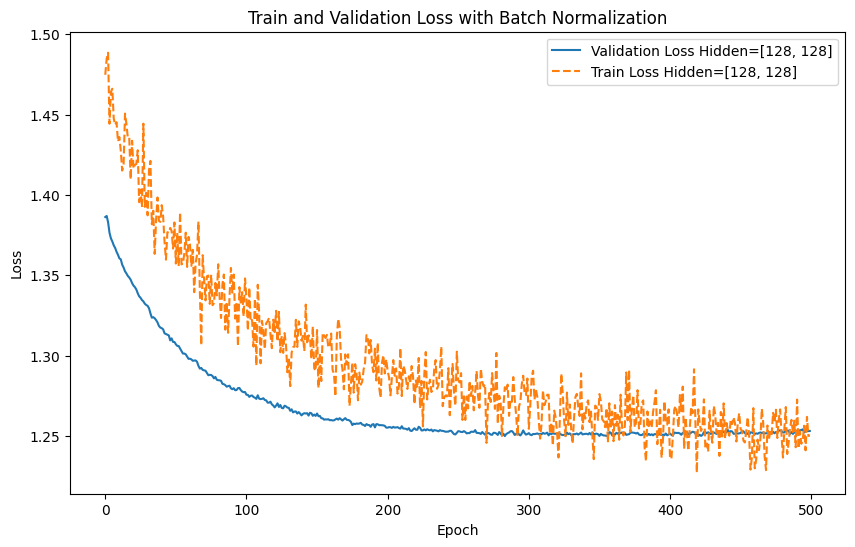

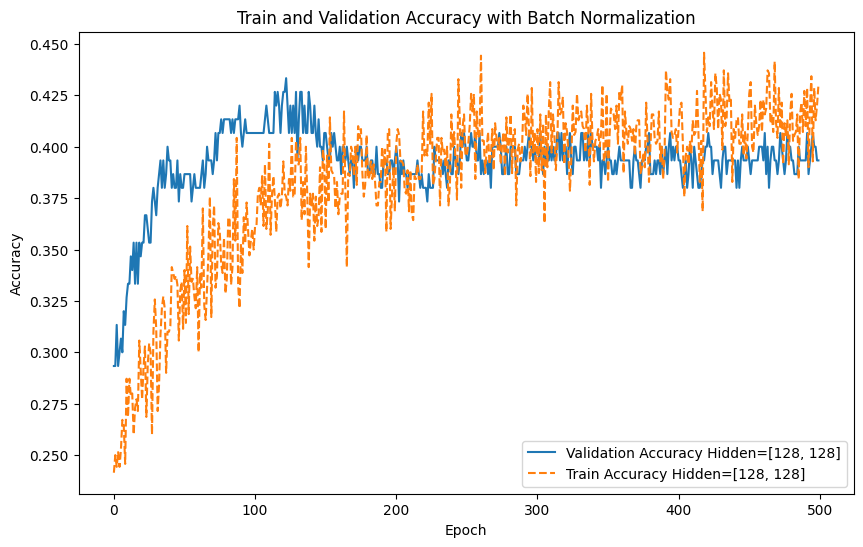

The best model has hidden layer sizes [128, 128] with the lowest validation loss at epoch 284. Validation loss: 1.2501

Classification Report for the Best Model:
              precision    recall  f1-score   support

           0       0.51      0.64      0.57        39
           1       0.37      0.23      0.29        30
           2       0.44      0.48      0.46        44
           3       0.38      0.35      0.37        37

    accuracy                           0.44       150
   macro avg       0.42      0.43      0.42       150
weighted avg       0.43      0.44      0.43       150



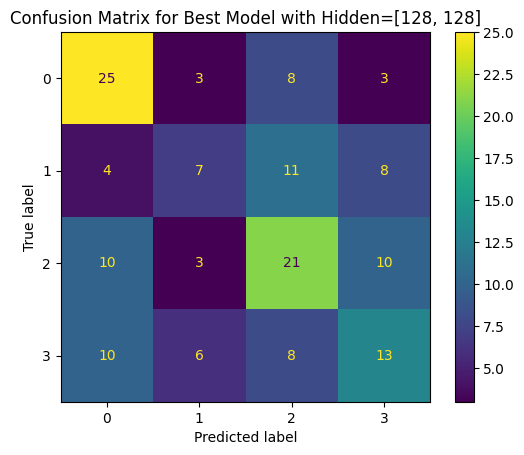

In [76]:
import torch
import torch.nn as nn

class TwoHiddenNNWithBatchNorm(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, dropout_prob=0.5):
        super(TwoHiddenNNWithBatchNorm, self).__init__()
        self.hidden1 = nn.Linear(input_size, hidden_sizes[0])  # First hidden layer
        self.batch_norm1 = nn.BatchNorm1d(hidden_sizes[0])     # Batch norm for first hidden layer
        self.hidden2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])  # Second hidden layer
        self.batch_norm2 = nn.BatchNorm1d(hidden_sizes[1])     # Batch norm for second hidden layer
        self.dropout = nn.Dropout(dropout_prob)                # Dropout layer
        self.output = nn.Linear(hidden_sizes[1], output_size)  # Output layer

    def swish(self, x):
        """Swish activation function: x * sigmoid(x)."""
        return x * torch.sigmoid(x)

    def forward(self, x):
        x = self.hidden1(x)                # Pass input through first hidden layer
        x = self.batch_norm1(x)            # Apply batch normalization
        x = self.swish(x)                  # Apply Swish activation
        x = self.dropout(x)                # Apply dropout
        x = self.hidden2(x)                # Pass through second hidden layer
        x = self.batch_norm2(x)            # Apply batch normalization
        x = self.swish(x)                  # Apply Swish activation
        x = self.dropout(x)                # Apply dropout
        x = self.output(x)                 # Pass through output layer
        return x


# Training and evaluation function
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs):
    train_loss, val_loss, train_acc, val_acc = [], [], [], []
    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * X_batch.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)
        train_loss.append(running_loss / total)
        train_acc.append(correct / total)

        # Validation phase
        model.eval()
        running_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                running_loss += loss.item() * X_batch.size(0)
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == y_batch).sum().item()
                total += y_batch.size(0)
        val_loss.append(running_loss / total)
        val_acc.append(correct / total)
    return train_loss, val_loss, train_acc, val_acc

# Train models with different hidden layer sizes
input_size = X_train_tensor.shape[1]
output_size = len(y_train.unique())
hidden_layer_configs = [[128, 128]]
epochs = 500
results = []

for hidden_sizes in hidden_layer_configs:
    model = TwoHiddenNNWithBatchNorm(input_size, hidden_sizes, output_size)
    criterion = nn.CrossEntropyLoss()
    optimizer = optimizer = ADOPT(model.parameters(), lr=1e-5, weight_decay=0.0001)
    train_loss, val_loss, train_acc, val_acc = train_model(
        model, train_loader, val_loader, criterion, optimizer, epochs
    )
    results.append({
        "hidden_sizes": hidden_sizes,
        "train_loss": train_loss,
        "val_loss": val_loss,
        "train_acc": train_acc,
        "val_acc": val_acc,
        "model": model
    })

# Save only the last epoch's results to CSV
last_epoch_data = []
for res in results:
    last_epoch_data.append({
        "hidden_sizes": res["hidden_sizes"],
        "train_loss": res["train_loss"][-1],
        "val_loss": res["val_loss"][-1],
        "train_acc": res["train_acc"][-1],
        "val_acc": res["val_acc"][-1],
    })

df_last_epoch = pd.DataFrame(last_epoch_data)
df_last_epoch.to_csv("results_two_hidden_batch_norm_last_epoch.csv", index=False)

# Plot losses and accuracies
plt.figure(figsize=(10, 6))
for res in results:
    label = f"Hidden={res['hidden_sizes']}"
    plt.plot(res["val_loss"], label=f"Validation Loss {label}")
    plt.plot(res["train_loss"], linestyle="--", label=f"Train Loss {label}")
plt.title("Train and Validation Loss with Batch Normalization")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
for res in results:
    label = f"Hidden={res['hidden_sizes']}"
    plt.plot(res["val_acc"], label=f"Validation Accuracy {label}")
    plt.plot(res["train_acc"], linestyle="--", label=f"Train Accuracy {label}")
plt.title("Train and Validation Accuracy with Batch Normalization")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Find the best model based on the minimum validation loss
best_model = min(results, key=lambda x: min(x["val_loss"]))
best_epoch = best_model["val_loss"].index(min(best_model["val_loss"])) + 1
best_hidden_sizes = best_model["hidden_sizes"]

# Print the best model information
print(f"The best model has hidden layer sizes {best_hidden_sizes} with the lowest validation loss "
      f"at epoch {best_epoch}. Validation loss: {min(best_model['val_loss']):.4f}")


# Evaluate the best model on the test set
best_model["model"].eval()
y_true, y_pred = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = best_model["model"](X_batch)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(y_batch.tolist())
        y_pred.extend(predicted.tolist())

# Generate confusion matrix and classification report
cm = confusion_matrix(y_true, y_pred)
print("\nClassification Report for the Best Model:")
print(classification_report(y_true, y_pred))
ConfusionMatrixDisplay(cm).plot()
plt.title(f"Confusion Matrix for Best Model with Hidden={best_hidden_sizes}")
plt.show()


In [77]:
model_2 = best_model

In [86]:
# prompt: select 10 sample from data loader and test model_1 and model_2

import torch
from torch.utils.data import DataLoader, TensorDataset, SubsetRandomSampler

# Assuming X_train_tensor, y_train, and test_loader are defined in your previous code
# Sample 10 indices from the training data
indices = torch.randperm(len(X_train_tensor))[:10]
sampler = SubsetRandomSampler(indices)
sample_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=1, sampler=sampler)


# Function to evaluate a model on a data loader
def evaluate_model(model, data_loader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            outputs = model(X_batch)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(y_batch.tolist())
            y_pred.extend(predicted.tolist())
    return y_true, y_pred


# Test model_1 (assuming model_1["model"] is the trained model)
print("Model 1 Evaluation:")
y_true_1, y_pred_1 = evaluate_model(model_1["model"], sample_loader)
print(f"True Labels: {y_true_1}")
print(f"Predicted Labels: {y_pred_1}")

# Test model_2 (assuming model_2["model"] is the trained model)
print("\nModel 2 Evaluation:")
y_true_2, y_pred_2 = evaluate_model(model_2["model"], sample_loader)
print(f"True Labels: {y_true_2}")
print(f"Predicted Labels: {y_pred_2}")

Model 1 Evaluation:
True Labels: [1, 0, 1, 3, 2, 1, 2, 1, 3, 1]
Predicted Labels: [1, 0, 1, 3, 2, 0, 0, 0, 1, 1]

Model 2 Evaluation:
True Labels: [1, 2, 2, 1, 0, 3, 1, 3, 1, 1]
Predicted Labels: [3, 0, 2, 0, 0, 1, 1, 3, 3, 0]


Ensemble Accuracy: 0.42

Ensemble Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.62      0.54        39
           1       0.29      0.20      0.24        30
           2       0.43      0.48      0.45        44
           3       0.40      0.32      0.36        37

    accuracy                           0.42       150
   macro avg       0.40      0.40      0.40       150
weighted avg       0.41      0.42      0.41       150



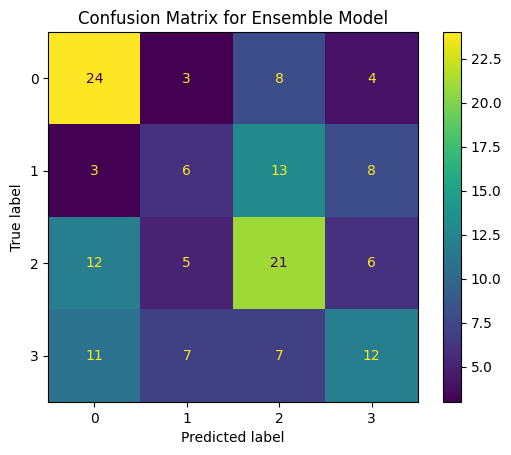

In [84]:
def ensemble_predictions(model_1, model_2, test_loader):
    model_1["model"].eval()
    model_2["model"].eval()
    y_true, y_pred_ensemble = [], []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs_1 = model_1["model"](X_batch)
            outputs_2 = model_2["model"](X_batch)
            ensemble_outputs = (outputs_1 + outputs_2) / 2
            _, predicted_ensemble = torch.max(ensemble_outputs, 1)
            y_true.extend(y_batch.tolist())
            y_pred_ensemble.extend(predicted_ensemble.tolist())

    # Calculate accuracy
    accuracy = accuracy_score(y_true, y_pred_ensemble)
    print(f"Ensemble Accuracy: {accuracy}")

    # Generate confusion matrix and classification report
    cm = confusion_matrix(y_true, y_pred_ensemble)
    print("\nEnsemble Classification Report:")
    print(classification_report(y_true, y_pred_ensemble))

    ConfusionMatrixDisplay(cm).plot()
    plt.title("Confusion Matrix for Ensemble Model")
    plt.show()

    return accuracy

ensemble_accuracy = ensemble_predictions(model_1, model_2, test_loader)